# TP4: Travail Final 
## VANBELLE Julien

## Imports

In [13]:
import os
import yake
import collections
import string
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import nltk
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from nltk import FreqDist
from nltk.corpus import webtext
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('webtext')
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import Image
from collections import defaultdict
from pprint import pprint
import sys
import spacy
from spacy.lang.fr.examples import sentences
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from tabulate import tabulate

txt_path = '/Users/julienvanbelle/Documents/GitHub/tac/data/txt'
data_path = '/Users/julienvanbelle/Documents/GitHub/tac/data'


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julienvanbelle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     /Users/julienvanbelle/nltk_data...
[nltk_data]   Package webtext is already up-to-date!


## Data cleaning

In [ ]:
files = os.listdir(txt_path)
data_bxl = [f for f in files if f.startswith('Bxl_')]
len(data_bxl)


In [ ]:
data_list = []
for txt in data_bxl:
    with open(os.path.join(txt_path, txt), 'r', encoding = "ISO-8859-1") as f:
        data_list.append(f.read())

len(data_list)


In [ ]:
# Ecrire tout le contenu dans un fichier temporaire pour le nettoyer des stopwords propore au corpus
if not os.path.exists(data_path):
    os.mkdir(data_path)
with open(os.path.join(data_path, f'_temp.txt'), 'w') as f:
    f.write(' '.join(data_list))
    print("temp file saved in",data_path)

In [ ]:
wt_words = webtext.words('{}/_temp.txt'.format(data_path))
data_analysis = nltk.FreqDist(wt_words)
 
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 3])
data_analysis = nltk.FreqDist(filter_words)
data_analysis.plot(30, cumulative=False)

In [ ]:
addsw = []
for z in sorted(filter_words):
  if filter_words[z] > 25000:
   addsw.append(z)

print(addsw)

In [ ]:
# Stopwords
swLower = ' '.join(str(e).lower() for e in addsw)
sw = stopwords.words("french")
sw += addsw
sw += swLower
sw += "conseil communal", "conseil général", "conseil supérieur", "administration communale", "conseil provincial", "l'administration communale", "conseil", "echevin" , "messieurs", "bruxelles", "bourgmestre", "collège", "être"
sw = set(sw)
print(sw)

In [ ]:
def clean_text(u, folder=None):
    if folder is None:
        input_path = f".txt"
        output_path = f"_clean.txt"
    else:
        ##for u in data_bxl:
            input_path = f"{folder}" + "/" + u
            output_path = data_path + "/txt_cleaned/" + "Clean_" + u ##opti ici avec {folder}
            print("Cleaning ==> " +u)
    
            output = open(output_path, "w", encoding="ISO-8859-1")
            with open(input_path, encoding="ISO-8859-1") as g:
                text = g.read()
                words = nltk.wordpunct_tokenize(text)
                kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
                kept_string = " ".join(kept)
                output.write(kept_string)
            return f'Output has been written in {data_path + "/txt_cleaned"}!'

In [ ]:

if not os.path.exists(data_path +"/txt_cleaned"):
    os.mkdir(data_path + "/txt_cleaned")
for x in data_bxl:
    clean_text(x, folder=txt_path)

In [ ]:
# Vérifier le résultat
with open(os.path.join(data_path + "/txt_cleaned/" + "Clean_" + data_bxl[0]), 'r', encoding="ISO-8859-1") as f:
    after = f.read()

after[:5000]

In [14]:
clean_path = data_path + "/txt_cleaned/"

clean_files = os.listdir(clean_path)
clean_list = []
for j in clean_files:
    with open(os.path.join(clean_path, j), 'r', encoding = "ISO-8859-1") as f:
        clean_list.append(f.read())

len(clean_list)

2678

## Analyse de la thématique des travaux liè au tram à Bruxelles

### Analyse des mots clés sur l'ensemble du corpus nettoyé

In [15]:
# Instantier l'extracteur de mots clés
kw_extractor = yake.KeywordExtractor(lan="fr", top=100)
kw_extractor

import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())
print(pool)

<multiprocessing.pool.Pool state=RUN pool_size=4>


In [ ]:
def keyextract():
    for f in sorted(data_cleaned):
        text = open(os.path.join(clean_path, f), 'r', encoding="ISO-8859-1").read()
        keywords = kw_extractor.extract_keywords(text.lower())
        kept = []
        for kw, score in keywords:
            words = kw.split()
            if len(words) == 2 and kw.lower() not in sw:
                kept.append(kw)
        print(f"{f} mentions these keywords: {', '.join(kept)}...")
    

In [ ]:
pool.map(keyextract())
pool.close

### TF/IDF

In [16]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

In [17]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

In [18]:
%time tfidf_vectors = vectorizer.fit_transform(clean_list)

CPU times: user 2min 52s, sys: 1.37 s, total: 2min 53s
Wall time: 2min 57s


In [19]:
# Détail de la matrice
tfidf_vectors

<2678x5387 sparse matrix of type '<class 'numpy.float64'>'
	with 3185342 stored elements in Compressed Sparse Row format>

In [20]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

vermeire       0.402884
coelst         0.326803
meulebroeck    0.204466
noode          0.184730
tramways       0.158508
                 ...   
gebouwen       0.000000
gebracht       0.000000
gebruik        0.000000
gedaan         0.000000
lagasse        0.000000
Length: 5387, dtype: float64

### K-means

In [33]:
N_CLUSTERS = 3

km_model = KMeans(n_clusters=N_CLUSTERS)

In [34]:
clusters = km_model.fit_predict(tfidf_vectors)

In [35]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(clean_list[idx])

In [17]:
pprint(dict(clustering)) ##bug ici 

### Visualisation des clusters

In [36]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [37]:
reduced_vectors[:10]

array([[-0.16858724,  0.23294572],
       [-0.10966449,  0.21039508],
       [-0.22045422, -0.17895544],
       [-0.17740367,  0.28158225],
       [ 0.5881496 ,  0.01194522],
       [-0.15104997, -0.01260909],
       [ 0.67109987, -0.1249806 ],
       [ 0.02593923,  0.46014792],
       [-0.18740627, -0.10926247],
       [-0.15939929, -0.106037  ]])

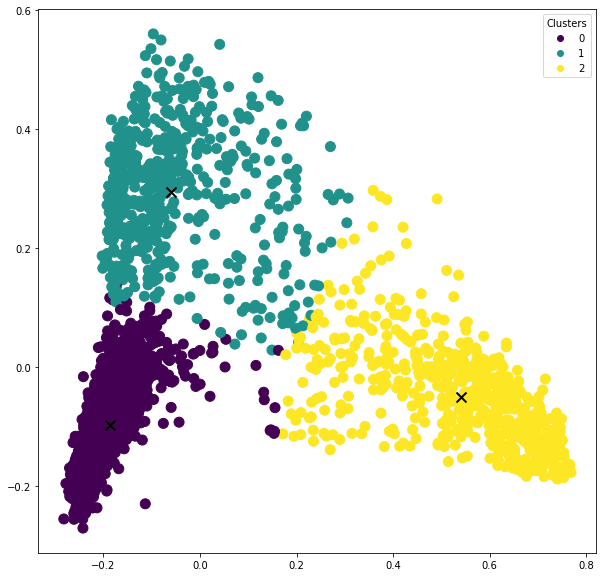

In [38]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")